#Processamento Natural de Linguagem de Avaliações da Amazon

Este conjunto de dados consiste em [reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv) de alimentos finos da Amazônia. Os dados abrangem um período de mais de 10 anos, incluindo todas as aproximadamente 500.000 análises até outubro de 2012. As análises incluem informações do produto e do usuário, classificações e uma análise em texto simples. Ele também inclui comentários de todas as outras categorias da Amazon.



## Importando bibliotecas

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import numpy as np

## Lendo os dados

In [2]:
import pandas as pd
df = pd.read_csv('/content/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 568454 rows and 10 columns


## Distribuição dos Scores dados aos produtos

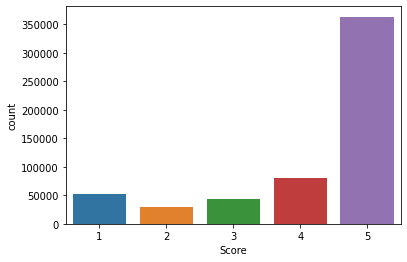

In [4]:
ax = sns.countplot(x="Score", data= df)

## Nuvem de palavras Gerais

In [5]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
# Create stopword list:

stoplist = set(stopwords.words("english"))
stoplist.update(["br", "href"])
textt = " ".join(review for review in df.Text)
wordcloud = WordCloud(stopwords=stoplist).generate(textt)


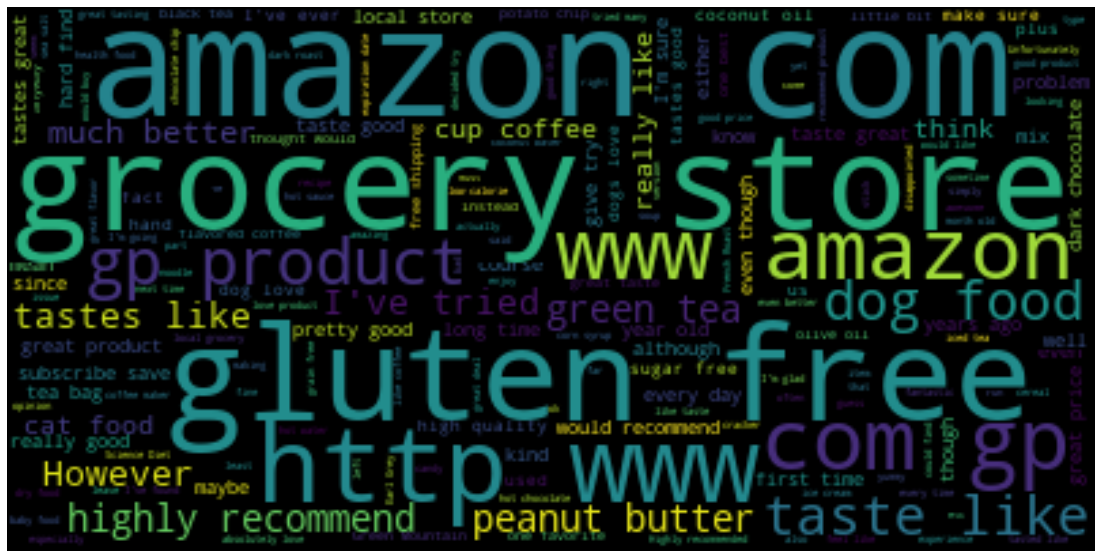

In [6]:
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

## Classificação De Scores

As críticas positivas serão classificadas como +1 e as críticas negativas serão classificadas como -1.
Classificaremos todos os comentários com ‘Pontuação’> 3 como +1, indicando que eles são positivos.
Todas as resenhas com ‘Pontuação’ <3 serão classificadas como -1. Avaliações com "Pontuação" = 3 serão descartadas, porque são neutras. Nosso modelo classificará apenas avaliações positivas e negativas.

In [7]:
df = df[df['Score'] != 3]
df['sentiment'] = df['Score'].apply(lambda rating : +1 if rating > 3 else -1)

In [8]:
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == -1]


In [9]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,-1
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1
...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,1
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,-1
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",1
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,1


## Nuvem de palavras positivas

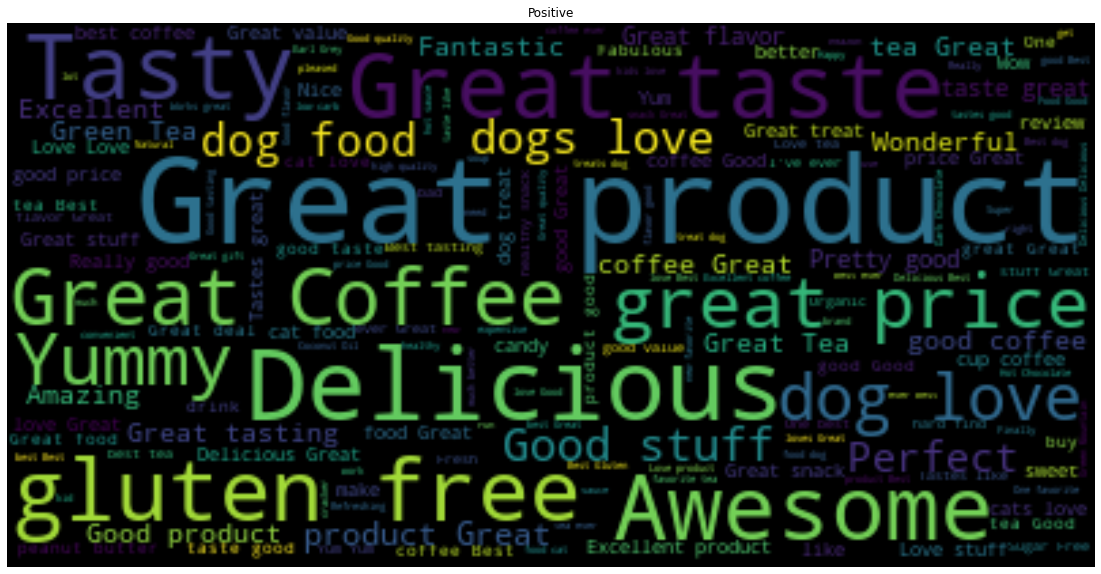

In [10]:
stoplist = set(stopwords.words("english"))
stoplist.update(["br", "href"])
pos = " ".join(review for review in positive.Summary)
wordcloud2 = WordCloud(stopwords=stoplist).generate(pos)

plt.figure(figsize=(20, 10))
plt.title("Positive")
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()


## Nuvem de palavras negativas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



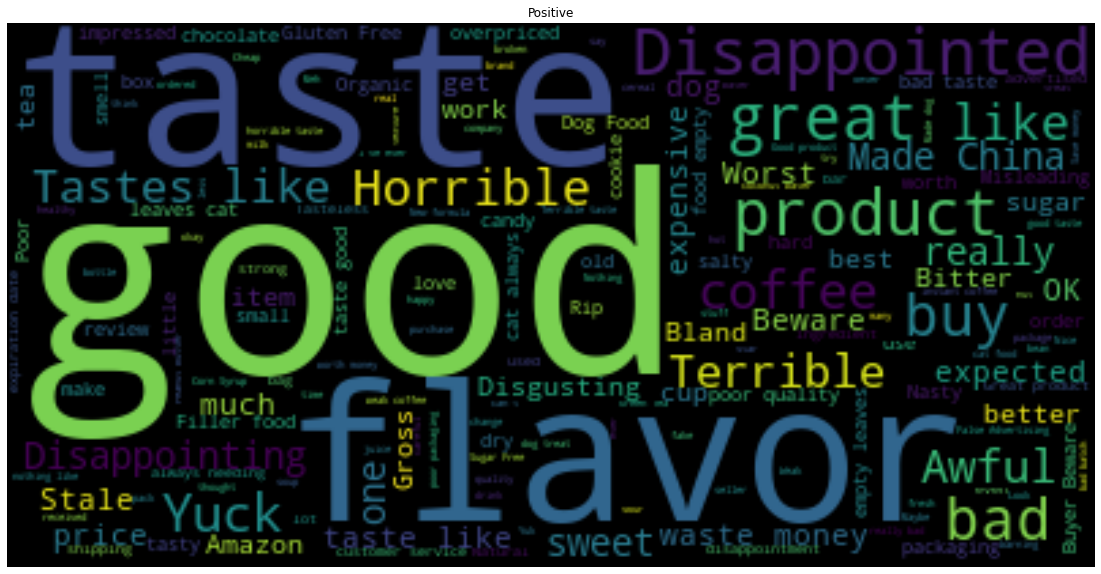

In [11]:
negative['Summary'] = negative.Summary.astype(str)
neg = " ".join(review for review in negative.Summary)
wordcloud2 = WordCloud(stopwords=stoplist).generate(neg)

plt.figure(figsize=(20, 10))
plt.title("Positive")
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

# Observação

Nuvem positiva: great, love, perfect

Nuvem negativa : Terrible, yuck, bad...

Observe que as palavras da nuvem positiva em sua maioria possuem palavras que indicam algo bom, entretanto, a nuvem negativa em sua maioria possuem palavras que indicam algo ruim

## Quantidade de sentimentos positivos e negativos

In [14]:
df['sentimentt'] = df['sentiment'].replace({-1 : 'negative'})
df['sentimentt'] = df['sentimentt'].replace({1 : 'positive'})

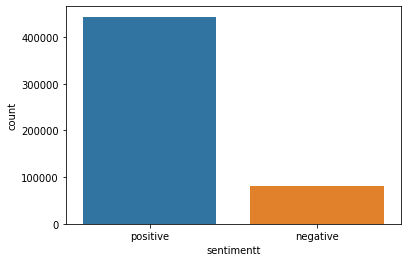

In [15]:
ax = sns.countplot(x="sentimentt", data= df)

## Pré-processamento
Retirada de pontuações

In [16]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"'))
    return final

In [17]:
df['Text'] = df['Text'].apply(remove_punctuation)
df = df.dropna(subset=['Summary'])
df['Summary'] = df['Summary'].apply(remove_punctuation)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
dfNew = df[['Summary','sentiment']]
dfNew.head()

,Summary,sentiment
0,Good Quality Dog Food,1
1,Not as Advertised,-1
2,Delight says it all,1
3,Cough Medicine,-1
4,Great taffy,1


## Dividindo o dataset em treino e validação

In [21]:
index = df.index
df['random_number'] = np.random.randn(len(index))
train = df[df['random_number'] <= 0.8]
test = df[df['random_number'] > 0.8]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Vetorização

Transforma palavras em vetores

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['Summary'])
test_matrix = vectorizer.transform(test['Summary'])

## Utilizando Modelo de Regressão Logística

Regressão Logistica é uma técnica estatística que tem como objetivo produzir, a partir de um conjunto de observações, um modelo que permita a predição de valores tomados por uma variável categórica, frequentemente binária, em função de uma ou mais variáveis independentes contínuas e/ou binárias.

In [47]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(verbose=1, solver = 'saga', n_jobs = 1)

In [48]:
X_train = train_matrix
X_test = test_matrix
y_train = train['sentiment']
y_test = test['sentiment']

In [49]:
lr.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 70 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



max_iter reached after 71 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=1,
                   warm_start=False)

## Resultados e Predição 

Existem pontos de melhoria no modelo, pode-se aplicar tecnicas de fairness e pre-processamento mais avançados já que o datatset é desbalanceado. Entretanto a acurácia está com um valor regular.

In [50]:
predictions = lr.predict(X_test)

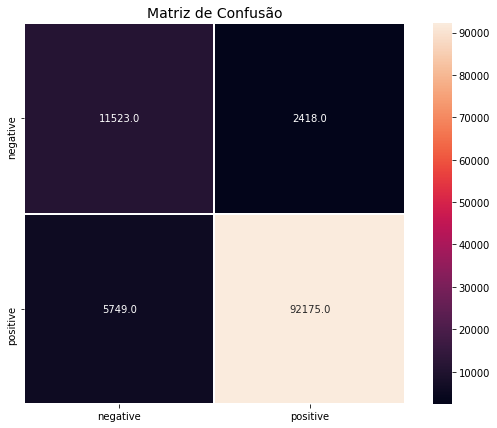

In [58]:
from sklearn.metrics import confusion_matrix,classification_report

new = np.asarray(y_test)
cm = confusion_matrix(predictions,y_test)
labels = ['negative', 'positive']

df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])

plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True , fmt = '.1f', square=1, linewidth=1.)
plt.title('Matriz de Confusão', fontsize=14)
plt.show()

In [59]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          -1       0.67      0.83      0.74     13941
           1       0.97      0.94      0.96     97924

    accuracy                           0.93    111865
   macro avg       0.82      0.88      0.85    111865
weighted avg       0.94      0.93      0.93    111865

